<a href="https://colab.research.google.com/github/nickdevreker/nickdevreker/blob/main/Kopie_van_Sessie_03_SVM_Opdracht_Opgave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opdracht Support Vector Machines & Hyperparametertuning

Support Vector Machine zijn ondanks hun leeftijd nog altijd populair en heel frequent gebruikte ML algoritmes. Ze zijn bijzonder veelzijdig en kunnen ingezet worden bij zowel classificatieproblemen als regressieproblemen en zelfs bij het opsporen van uitschieters.



In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from scipy.stats import randint 
from scipy.stats import uniform
from skimage.io import imread, imshow

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)


## Vraag 2. Insurance

De dataset insurance bevat gegevens over klanten van een verzekeringsmaatschappij die autoverzekeringen heeft aangeboden. De 'Response' variabele geeft weer of die klanten hebben ingetekend op een verzekeringscontract.
De features zijn de volgende:
- id = klantennummer
- Gender = geslacht van de klant (man of vrouw)
- Age = leeftijd in jaren van de klant 
- Driving_Licence = of de klant over een rijbewijs beschikt
- Region_Code = gegevens over waar de klant woont
- Previously_Insured = was de klant vroeger al eens verzekerd (1 of 0)
- Vehicle_Age = leeftijd van het voertuig
- Vehicle_Damage = of het voertuig als dan niet is beschadigd (Ja of Nee)
- Annual_Premium = bedrag van de verzekeringspremie
- Policy_Sales_Channel = hoe de verzekering wordt aangeboden (categorische feature)
- Vintage = Hoe lang tot op vandaag de klant al is verzekerd (in dagen uitgedrukt).

De bedoeling is om een zo classifier (logistic regression of SVM) te trainen die zo goed mogelijk kan voorspellen of een potentiële klant zal ingaan op een verzekeringsvoorstel.

Doorloop volgende stappen:

- Contoleer de gebalanceerheid van de dataset. Wat is de verhouding van de twee klasses?
- Verwijder de feature 'id'.
- Onderzoek of de kolom Driving_Licence in verwijderd kan worden.
- Verander categorische variabelen naar numerieke variabelen. Dit kan door binaire categorieën om te zetten naar 1/0 en door one-hot encoding toe te passen daar waar meerdere categorieën aanwezig zijn.
- Splits op in features en targets en vervolgens in een training set en test set. Zorg voor een test set met 80000 samples. Scale de dataset.
- Train een logistic regression model en SVM. Dit mag onmiddellijk via cross-validatie gebeuren.
- Onderzoek in welke mate het model last heeft van de ongebalanceerdheid van de dataset.
- Teken de ROC-curve. Kan je hieruit aflezen of de classifier al dan niet last heeft van niet-gebalanceerd.
- Teken nu ook de Precision-Recall curve. Wat kan je hieruit besluiten?
- De verzeringsmaatschappij wil graag een model dat een macro_f1 score haalt op de test set die zo hoog mogelijk ligt (liefst hoger ligt dan 75%). Bekijk nu opnieuw de ROC-curve en de Precision-Recall curve. Wat kan je besluiten?
- Onderzoek of je door het weglaten van bepaalde features betere resultaten haalt. 

### OPMERKING

Omwille van de omvang de dataset kan het trainen van de modellen bijzonder intensief zijn. Daarom is het toegestaan om de training set (drastisch) te verkleinen.
Het kan wel zijn dat de performantie van het model daalt wanneer je minder training dat gebruikt. In dat geval kan het zijn dat een macro_f1 score van 75% niet haalbaar is. Probeer dan een zo hoog mogelijke macro_f1 score te bekomen.

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HOWEST/Sessie 3 SVM/oefening/Sessie_03_Support_Vector_Machines_Opdracht/insurance.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max.columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
dataset.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [ ]:
# Uitwerking 


Contoleer de gebalanceerheid van de dataset. Wat is de verhouding van de twee klasses?

   aantal  procent
0  319553    83.62
1   62601    16.38


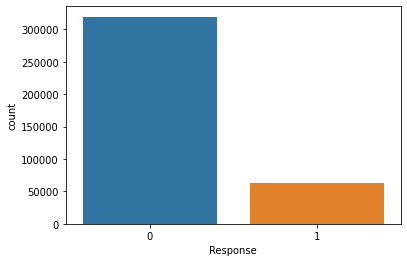

In [ ]:
sns.countplot(x='Response',  data=dataset)
aantal = dataset['Response'].value_counts()
procent = dataset['Response'].value_counts(normalize=True)*100
tabel = pd.DataFrame({'aantal' : aantal, 'procent' : round(procent,2)})
print(tabel)

Verwijder de feature 'id'.

In [ ]:

dataset = dataset.drop('id', axis=1)

Onderzoek of de kolom Driving_Licence in verwijderd kan worden.

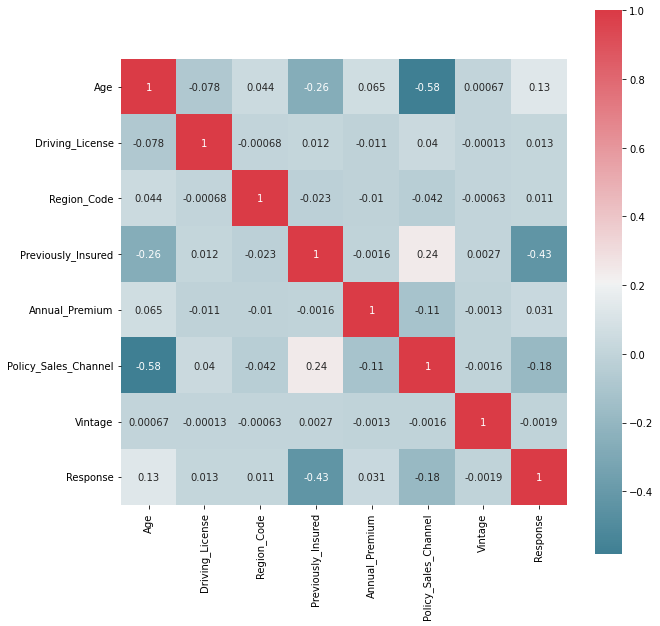

In [ ]:
corr = dataset.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10,as_cmap=True), square=True, ax=ax, annot=True)

Verander categorische variabelen naar numerieke variabelen. Dit kan door binaire categorieën om te zetten naar 1/0 en door one-hot encoding toe te passen daar waar meerdere categorieën aanwezig zijn.

In [ ]:
mapping = {'Male': 1, 'Female': 0}

dataset['Gender'] = dataset['Gender'].replace(mapping)

In [ ]:
mapping = {'Yes': 1, 'No': 0}

dataset['Vehicle_Damage'] = dataset['Vehicle_Damage'].replace(mapping)

In [ ]:
dataset = pd.concat([dataset,pd.get_dummies(dataset['Vehicle_Age'], prefix='V_age')],axis=1)
dataset.drop(['Vehicle_Age'],axis=1, inplace=True)
dataset.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,V_age_1-2 Year,V_age_< 1 Year,V_age_> 2 Years
0,1,22,1,7.0,1,0,2630.0,152.0,16,0,0,1,0
1,1,42,1,28.0,0,1,43327.0,26.0,135,0,1,0,0
2,0,66,1,33.0,0,1,35841.0,124.0,253,0,1,0,0
3,0,22,1,33.0,0,0,27645.0,152.0,69,0,0,1,0
4,1,28,1,46.0,1,0,29023.0,152.0,211,0,0,1,0


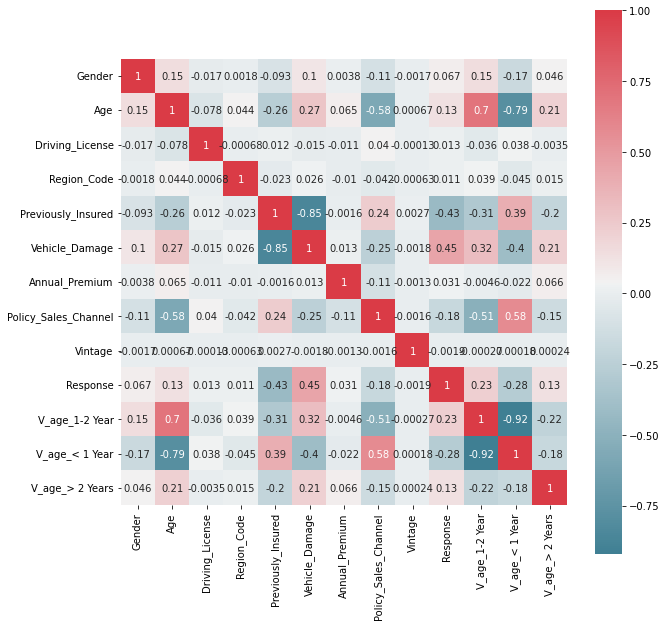

In [ ]:
corr = dataset.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10,as_cmap=True), square=True, ax=ax, annot=True)

In [ ]:
droplist = ['Gender', 'Driving_License', 'Region_Code', 'Annual_Premium', 'Vintage']
for i in droplist:
  dataset = dataset.drop(i, axis=1)

In [ ]:
dataset.columns

Index(['Age', 'Previously_Insured', 'Vehicle_Damage', 'Policy_Sales_Channel',
       'Response', 'V_age_1-2 Year', 'V_age_< 1 Year', 'V_age_> 2 Years'],
      dtype='object')

Splits op in features en targets en vervolgens in een training set en test set. Zorg voor een test set met 80000 samples. Scale de dataset.

In [ ]:
y = dataset.Response.values
X = dataset.drop('Response',axis=1)

In [ ]:
# example of random undersampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = make_classification(n_samples=1000, weights=[0.99], flip_y=0)
# summarize class distribution
print(Counter(y))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_over, y_over = undersample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

Counter({0: 990, 1: 10})
Counter({0: 10, 1: 10})


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state =0)

In [ ]:

scaler = preprocessing.StandardScaler().fit(X_train)  # Normaliseer naar gemiddelde = 0 en standaardafwijking = 1

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Train een logistic regression model en SVM. Dit mag onmiddellijk via cross-validatie gebeuren.

In [ ]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')
X_resampled, y_resampled= tl.fit_resample(X_train, y_train)


# train

model.fit(X_resampled,y_resampled)







model = SVC(probability=True)
paramaters = [ 
        {'kernel': ['linear'], 'C': np.linspace(0.01,20,10)},
        {'kernel': ['rbf'], 'C': np.linspace(0.01,20,10), 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2]},
        {'kernel': ['poly'], 'C':np.linspace(0.01,20,10)} ]
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy', # roc_auc, f1_weighted, f1_macro, recall, ...
                           cv = 15,
                           n_jobs = -1,
                           verbose =5)
grid_search = grid_search.fit(X_train, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_ 

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
print(accuracy_score(y_test, y_pred) * 100) 
# ROC
probs = grid_search.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Fitting 15 folds for each of 70 candidates, totalling 1050 fits
